### Bandpass Intervals

4 - 8 Hz 

8- 13 Hz

8 - 25 Hz

13 - 20 Hz

20 - 28 Hz


In [2]:
from EEGModels import EEGNet
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import os
import scipy
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from IPython.display import display, HTML


In [3]:
%run "../../functions/bandpass.ipynb"
%run "../../functions/get_data.ipynb"
%run "../../functions/trimmer.ipynb"
%run "../../functions/training.ipynb"

# DATA PREPROCESSING AND FILTERING

In [16]:
folder_path = '../../data/initial_data/dance_inst_clean/'
file_list = get_file_list(folder_path)

print(file_list)

['../../data/initial_data/dance_inst_clean/P_1.mat', '../../data/initial_data/dance_inst_clean/P_10.mat', '../../data/initial_data/dance_inst_clean/P_2.mat', '../../data/initial_data/dance_inst_clean/P_3.mat', '../../data/initial_data/dance_inst_clean/P_4.mat', '../../data/initial_data/dance_inst_clean/P_5.mat', '../../data/initial_data/dance_inst_clean/P_9.mat', '../../data/initial_data/dance_inst_clean/S_1.mat', '../../data/initial_data/dance_inst_clean/S_10.mat', '../../data/initial_data/dance_inst_clean/S_2.mat', '../../data/initial_data/dance_inst_clean/S_3.mat', '../../data/initial_data/dance_inst_clean/S_4.mat', '../../data/initial_data/dance_inst_clean/S_5.mat', '../../data/initial_data/dance_inst_clean/S_9.mat']


We would now run the get_discontinuous_files() function,but on this set of data we already knowthat the function will not be able to find anything.

In [5]:
X, Y = get_data(file_list)

In [6]:
kick_out = [(7, [36, 50, 54]), (10, [50])]

file_dict = {0: 'P_1', 1: 'P_10', 2: 'P_2', 3: 'P_3', 4: 'P_4', 5: 'P_5', 6: 'P_9', 7: 'S_1', 8: 'S_10', 
             9: 'S_2', 10: 'S_3', 11: 'S_4', 12: 'S_5', 13: 'S_9'}

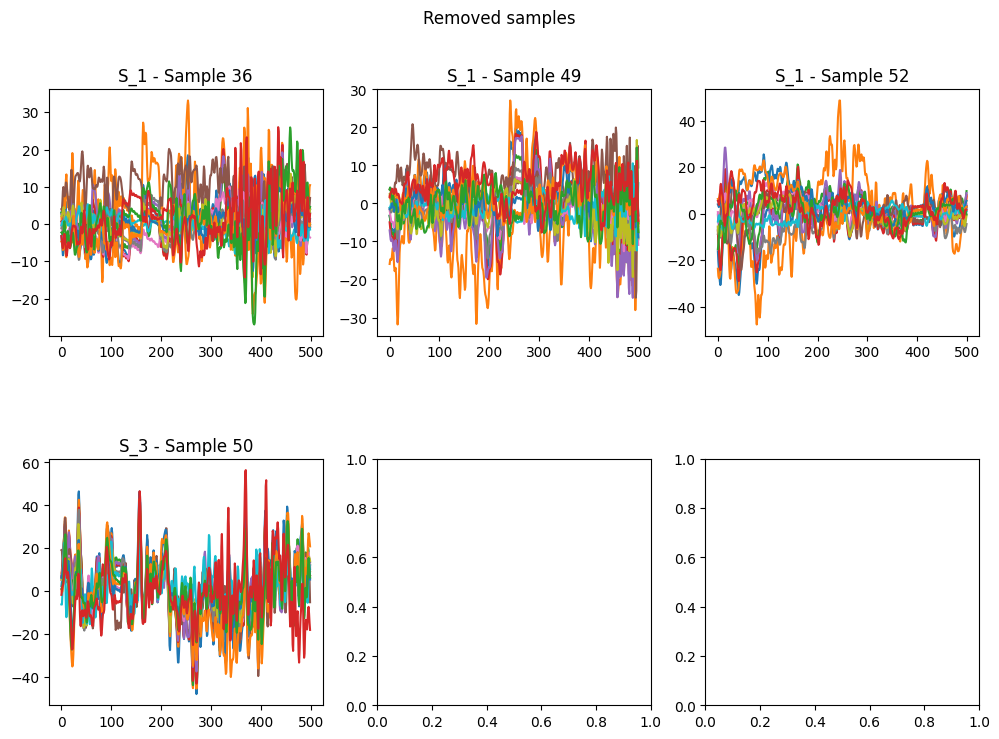

In [7]:
new_X, new_Y = trim_manually(kick_out, X, Y, file_dict, print_out=True)

In [8]:
print_eliminations(file_list, new_X, new_Y, print_shape=True)

(48, 14, 750) -> (48, 14, 500) (48, 2)
(31, 14, 750) -> (31, 14, 500) (31, 2)
(49, 14, 750) -> (49, 14, 500) (49, 2)
(47, 14, 750) -> (47, 14, 500) (47, 2)
(66, 14, 750) -> (66, 14, 500) (66, 2)
(48, 14, 750) -> (48, 14, 500) (48, 2)
(49, 14, 750) -> (49, 14, 500) (49, 2)
(66, 14, 750) -> (63, 14, 500) (63, 2)
(36, 14, 750) -> (36, 14, 500) (36, 2)
(42, 14, 750) -> (42, 14, 500) (42, 2)
(72, 14, 750) -> (71, 14, 500) (71, 2)
(47, 14, 750) -> (47, 14, 500) (47, 2)
(46, 14, 750) -> (46, 14, 500) (46, 2)
(57, 14, 750) -> (57, 14, 500) (57, 2)
Total samples removed:  4
Total samples remaining:  700


# BANDPASS FILTERING

In [9]:
fs = 250

In [10]:
filtered_data_4_8 = []
filtered_data_8_13 = []
filtered_data_8_25 = []
filtered_data_13_20 = []
filtered_data_20_28 = []
for x in new_X:
    filtered_x_4_8 = bandpass_filter(x, fs, 4, 8)
    filtered_x_8_13 = bandpass_filter(x, fs, 8, 13)
    filtered_x_8_25 = bandpass_filter(x, fs, 8, 25)
    filtered_x_13_20 = bandpass_filter(x, fs, 13, 20)
    filtered_x_20_28 = bandpass_filter(x, fs, 20, 28)
    filtered_data_4_8.append(filtered_x_4_8)
    filtered_data_8_13.append(filtered_x_8_13)
    filtered_data_8_25.append(filtered_x_8_25)
    filtered_data_13_20.append(filtered_x_13_20)
    filtered_data_20_28.append(filtered_x_20_28)

Print before and after visualisation of a random eeg signal

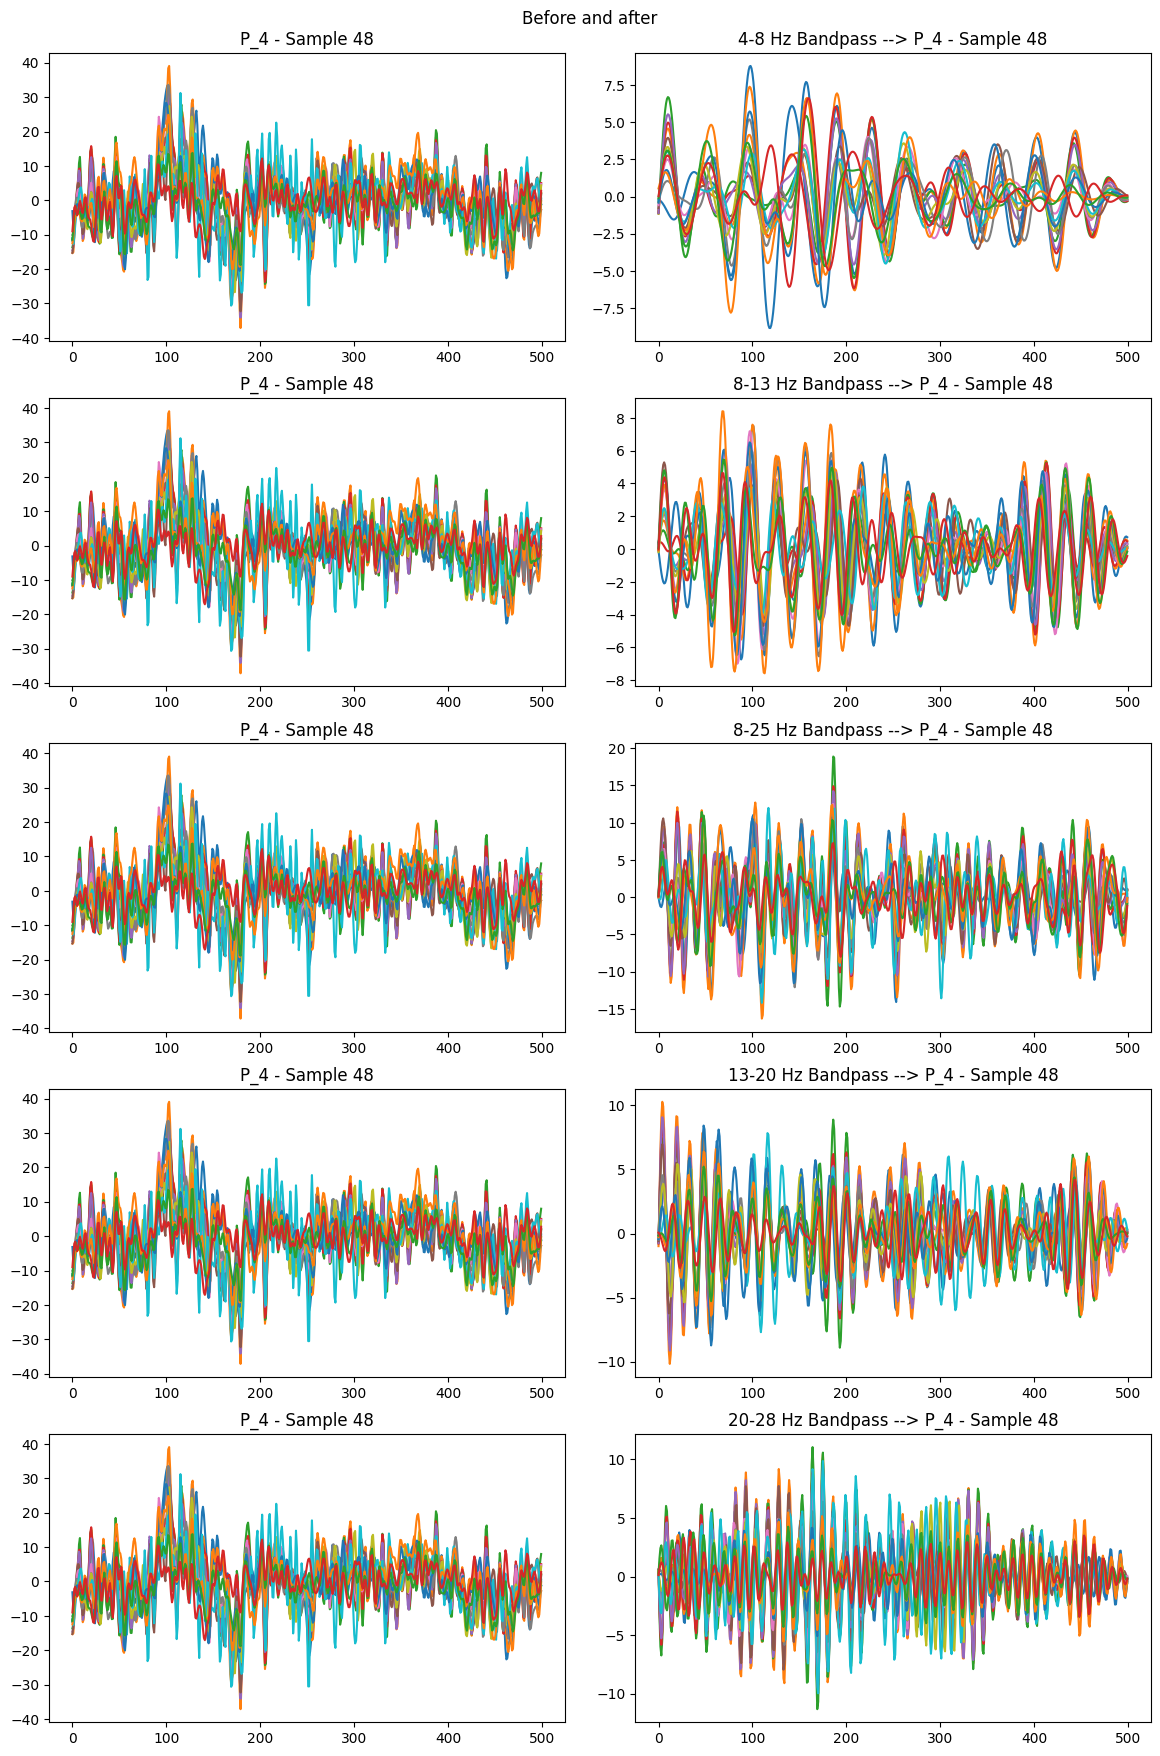

In [14]:
file_index = np.random.randint(0, 13)
sample_index = np.random.randint(0, new_X[file_index].shape[0])

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 18))
fig.suptitle('Before and after')
fig.tight_layout(pad=2.0)

plot_sample(new_X[file_index], sample_index, axes[0, 0], file_dict[file_index])
plot_sample(filtered_data_4_8[file_index], sample_index, axes[0, 1], "4-8 Hz Bandpass --> " + file_dict[file_index])
plot_sample(new_X[file_index], sample_index, axes[1, 0], file_dict[file_index])
plot_sample(filtered_data_8_13[file_index], sample_index, axes[1, 1], "8-13 Hz Bandpass --> " + file_dict[file_index])
plot_sample(new_X[file_index], sample_index, axes[2, 0], file_dict[file_index])
plot_sample(filtered_data_8_25[file_index], sample_index, axes[2, 1], "8-25 Hz Bandpass --> " + file_dict[file_index])
plot_sample(new_X[file_index], sample_index, axes[3, 0], file_dict[file_index])
plot_sample(filtered_data_13_20[file_index], sample_index, axes[3, 1], "13-20 Hz Bandpass --> " + file_dict[file_index])
plot_sample(new_X[file_index], sample_index, axes[4, 0], file_dict[file_index])
plot_sample(filtered_data_20_28[file_index], sample_index, axes[4, 1], "20-28 Hz Bandpass --> " + file_dict[file_index])

# TRAINING ON THE FILTERED DATA

In [15]:
scroll_style = """
<style>
.output {
    overflow-y: scroll;
    max-height: 300px; /* Adjust the height as per your preference */
}
</style>
"""

In [16]:
kernels, chans, samples = 1, 14, 500

In [ ]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, filtered_data_4_8, new_Y, "../results/dance_instr_clean/4_8_Hz.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../results/dance_instr_clean/4_8_Hz.txt")

In [ ]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, filtered_data_8_13, new_Y, "../results/dance_instr_clean/8_13_Hz.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../results/dance_instr_clean/8_13_Hz.txt")

In [ ]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, filtered_data_8_25, new_Y, "../results/dance_instr_clean/8_25_Hz.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../results/dance_instr_clean/8_25_Hz.txt")